1\. **Radioactive decay chain**

${\rm Tl}^{208}$ decays to ${\rm Pb}^{208}$ with a half-life $\tau$ of 3.052 minutes. Suppose to start with a sample of 1000 Thallium atoms and 0 of Lead atoms.

* Take steps in time of 1 second and at each time-step decide whether each Tl atom has decayed or not, accordingly to the probability $p(t)=1-2^{-t/\tau}$. Subtract the total number of Tl atoms that decayed at each step from the Tl sample and add them to the Lead one. Plot the evolution of the two sets as a function of time  
* Repeat the exercise by means of the inverse transform method: draw 1000 random numbers from the non-uniform probability distribution $p(t)=2^{-t/\tau}\frac{\ln 2}{\tau}$ to represent the times of decay of the 1000 Tl atoms. Make a plot showing the number of atoms that have not decayed as a function of time

In [178]:
import math
import numpy as np
import pandas as pd
from scipy import stats
from scipy.integrate import quad
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.interpolate import interp1d

import matplotlib.pyplot as plt
import seaborn as sns
#%matplotlib inline
#%precision 4

First exercise:

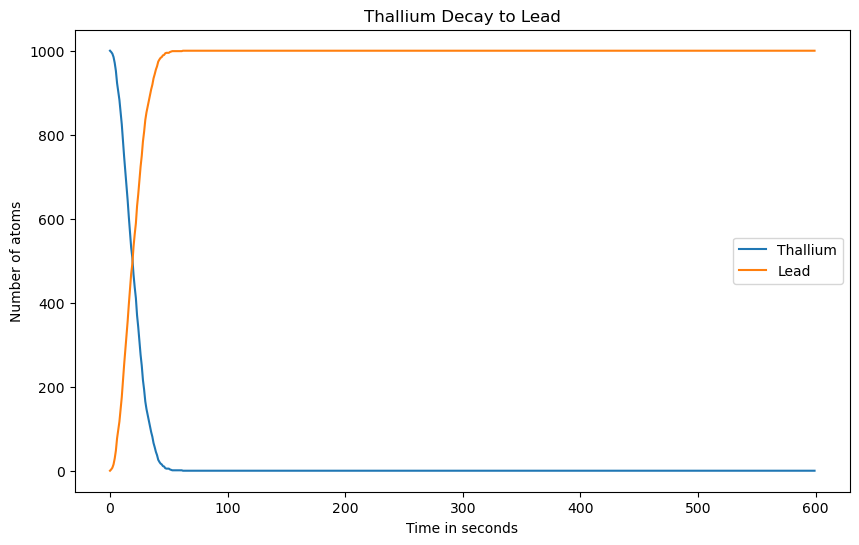

In [35]:
Tl = 1000
Pb = 0
rho = 3.052 * 60
t = np.arange(0, 600, 1)

# Defining the function that determines, from the given probability function, if the Thallium has decayed or not
def decay(t, Tl, Pb, rho):
    decayed = 0 # Starting with 0 decayed atoms
    thallium_atoms = np.zeros_like(t, dtype=int) # Initilizing two arrays of zeros the size of chosen timesteps (600)
    lead_atoms = np.zeros_like(t, dtype=int) 
    
    thallium_atoms[0] = Tl # Defining initial number of thallium atoms, making it the first element of the array
    lead_atoms[0] = Pb # Defining initial number of lead atoms, making it the first element of the array
    
    for i in range(1, len(t)):
        # At each timestep a random number is drawn, at if the number corresponds to the atom decaying, it is added to decayed
        decayed = np.random.rand(thallium_atoms[i - 1]) < (1 - 2**(-i/rho))
        thallium_atoms[i] = thallium_atoms[i - 1] - np.sum(decayed) # Number of thallium atoms is the previous minus the number of decayed atoms at the timestep
        lead_atoms[i] = lead_atoms[i - 1] + np.sum(decayed) # Number of lead atoms is the previous plus the number of decayed atoms at the timestep
            
    return thallium_atoms, lead_atoms


# Plotting the number of thallium and lead atoms over time
plt.figure(figsize=(10, 6))
plt.plot(t, thallium_atoms, label='Thallium')
plt.plot(t, lead_atoms, label='Lead')
plt.title('Thallium Decay to Lead')
plt.xlabel('Time in seconds')
plt.ylabel('Number of atoms')
plt.legend()
plt.show()

Second exercise with inverse transform method:

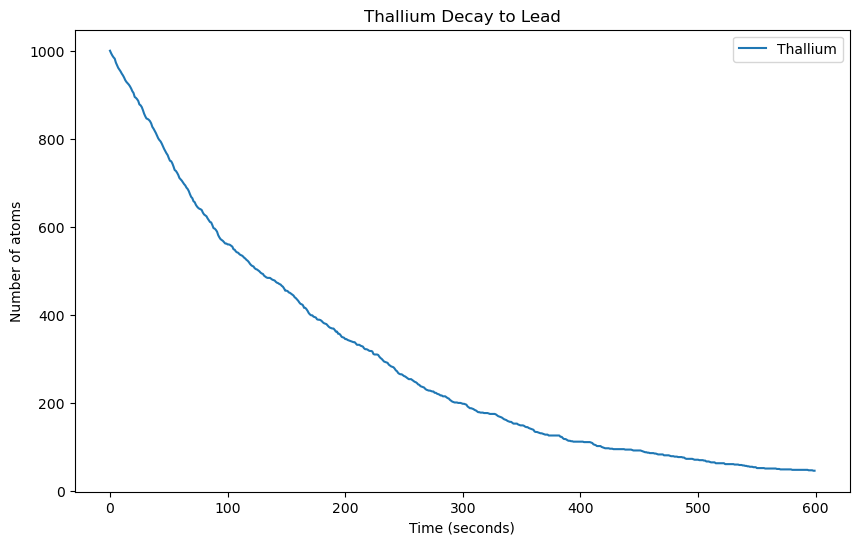

In [45]:
# Defining the inverse probability function for p(t)
def inverse_prob(t):
    return -3.052 * 60 * np.log(1 - t)


time = np.arange(0, 600, 1)
thallium_atoms = np.zeros_like(time) # Initilizing an array of zeros the size of chosen timesteps (600)


numbers = np.sort(np.random.rand(1000)) # sorting the computed random numbers in ascending order
decay_times = inverse_prob(numbers) # Running the inverse probability function with the random numbers sorted

for i, t in enumerate(time):
    thallium_atoms[i] = np.sum(decay_times > t) 


# Plotting the number of decayed thallium atoms over time    
plt.figure(figsize=(10, 6))
plt.plot(time, thallium_atoms, label='Thallium')
plt.title('Thallium Decay to Lead')
plt.xlabel('Time (seconds)')
plt.ylabel('Number of atoms')
plt.legend()
plt.show()


2\. **Monte Carlo integration: hit/miss vs mean value method**

Consider the function: 

$$f(x) =\sin^2{\left( \frac{1}{1-x} \right)}$$

* Plot the function and compute the integral of $f(x)$ between 0 and 2 with the hit/miss method. Evaluate the error of your estimate (hint: repeat the integral $N$ times, and from the distribution of the integrals take the mean value and the standard deviation, the latter rescaled by the appropriate factor)
* Repeat the integral with the mean value method. Evaluate the error and compare it with the previous one.

First exercise:

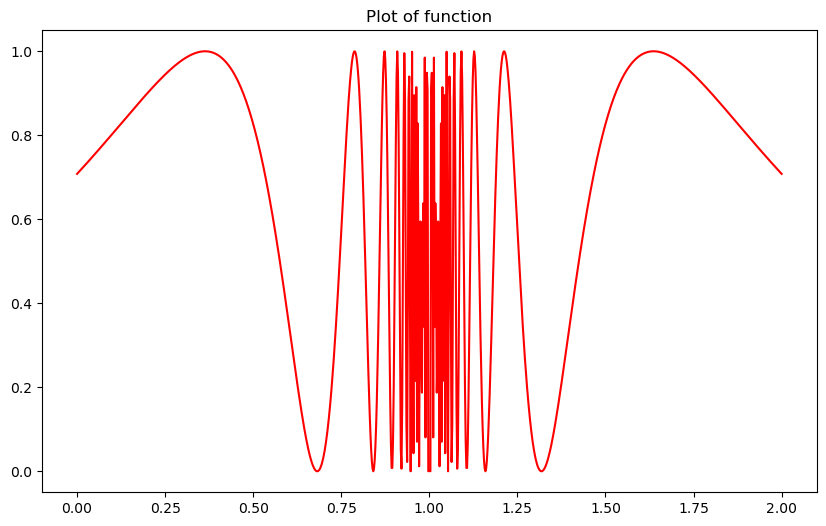

In [65]:
# plotting function
def f(x):
    return (np.sin(1. /(1-x)))**2

x_vals = np.linspace(0, 2, 1000)

plt.figure(figsize=(10, 6))
plt.plot(x_vals, f(x_vals), 'r-')
plt.title('Plot of function')
plt.show()

In [71]:
# Monte Carlo integration
def hit_miss(N, h, a, b):
    count = 0
    for i in range(N):
        x = h * np.random.random() # x is random uniform between 0 and 2
        y = (b - a) * np.random.random()     # y is random uniform between 0 and 1
        if y < f(x): count += 1
    I = count / N * h * (b - a)
    return I

N = 100000
a, b, h = 0, 1, 2


integr = hit_miss(N, h, a, b)
print("Integral:", integr)

Integral: 1.34754


In [72]:
# Error of estimate: Hit/miss method
M = 100

def calc_sigma(x_min, x_max, y_max, n, m):
    # Calculate the integral m times
    integrs = np.array([hit_miss(n, x_max, x_min, y_max) for mi in np.arange(m)])
    # Estimate sigma^2 as <I^2> - <I>^2
    sigma = np.sqrt(np.mean(integrs**2) - np.mean(integrs)**2)
    return sigma

sigma = calc_sigma(a, b, h, N, M)
print("Integral: %.3f +- %.3f" % (integr, sigma))

# From the result below it is clear that the error made in the estimation of the integral is small. 

Integral: 1.348 +- 0.003


Second exercise

In [73]:
# Mean value method
def mean_value(x_min, x_max, n):
    xi = np.random.uniform(x_min, x_max, n)
    yi = np.array([f(xii) for xii in xi])
    s = np.sum(yi)
    integ = (x_max - x_min) / n * s
    return integ

N = 100000
a, b = 0, 2

integr = mean_value(a, b, N)
print("Integral:", integr)

Integral: 1.347640755830388


In [74]:
# Error of estimate: Mean value method
M = 100

def calc_sigma(x_min, x_max, n, m):
    # Calculate the integral m times
    integrs = np.array([mean_value(x_min, x_max, n) for mi in np.arange(m)])
    # Estimate sigma^2 as <I^2> - <I>^2
    sigma = np.sqrt(np.mean(integrs**2) - np.mean(integrs)**2)
    return sigma

sigma = calc_sigma(a, b, N, M)
print("Integral: %.3f +- %.3f" % (integr, sigma))

# The result below show that with the mean value method the estimate is also very accurate with a small error. 

Integral: 1.348 +- 0.002


3\. **Monte Carlo integration in high dimension**

* Compute the area of a circle of unit radius, by integrating the function:

$$
f(x,y)=
\left\{
\begin{array}{ll}
      1 & x^2+y^2\le 1 \\
      0 & {\rm elsewhere}
\end{array} 
\right.
$$

* Generalize the result for a 10D sphere.

First exercise, using mean value method to estimate the area of a circle of unit radius

In [123]:
# Defining the function
def circle(x,y):
    if x**2 + y**2 <= 1:
        result = 1
    else:
        result = 0
    return result

In [124]:
# Mean value method
def mean_value(mini, maxi, n):
    xi = np.random.uniform(mini, maxi, n)
    yi = np.random.uniform(mini, maxi, n)
    zi = np.array([circle(x, y) for x, y in zip(xi, yi)])
    s = np.sum(zi)
    integ = (s / n) * 4 
    return integ

N = 100
a = -1
b = 1
integr = mean_value(a, b, N)
print("Area of circle of unit radius estimated with Monte Carlo integration:", integr)

Area of circle of unit radius estimated with Monte Carlo integration: 3.12


Second exercise, generalization of code for a 10D sphere

In [135]:
# Defining the function for 10D sphere
def circle_10D(x):
    if np.sum(x**2) <= 1:
        result = 1
    else:
        result = 0
    return result

In [136]:
# Mean value method for 10D sphere
def mean_value_sphere(m, n):
    xi = np.random.uniform(-1, 1, size=(n, m))
    zi = np.array([circle_10D(xii) for xii in xi])
    s = np.sum(zi)
    vol = 2**m
    integ = (s / n) * vol
    return integ

N = 10000

# Dimensions
M = 10


integr = mean_value_sphere(M, N)
print("Volume of 10 dimension sphere of unit radius estimated with Monte Carlo integration:", integr)

Volume of 10 dimension sphere of unit radius estimated with Monte Carlo integration: 2.6624


4\. **Monte Carlo integration with importance sampling** 

Calculate the value of the integral:

$$
I=\int_0^1 \frac{x^{-1/2}}{e^x+1} dx
$$

using the importance sampling method with $w(x)=1/\sqrt{x}$. You should expect a result around 0.84.

/var/folders/3v/tjxdxc4n36l_2fmq9pg38t0r0000gn/T/ipykernel_93692/1521896903.py:3: RuntimeWarning: divide by zero encountered in divide
  return 1/np.sqrt(x)
/var/folders/3v/tjxdxc4n36l_2fmq9pg38t0r0000gn/T/ipykernel_93692/1521896903.py:6: RuntimeWarning: divide by zero encountered in power
  return x**(-1/2)/(np.exp(x)+1)


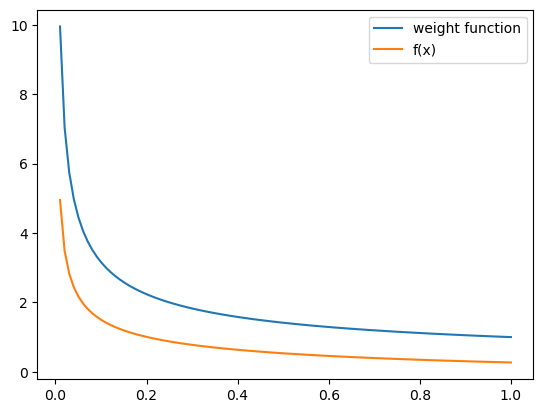

In [234]:
# Defining the weight function and the function given in the integral
def weight_func(x):
    return 1/np.sqrt(x)

def integral_func(x):
    return x**(-1/2)/(np.exp(x)+1)

    
x_vals = np.linspace(0, 1, 100)

plt.plot(x_vals, weight_func(x_vals), label='weight function')
plt.plot(x_vals, integral_func(x_vals), label='f(x)')
plt.legend()

In [235]:
# Function to calculate the CDF of the integral function
def cdf_integral(x):
    result, _ = quad(integral_func, 0, x)
    return result

In [236]:
%precision 10

# Computing the CDF value for the integral function in the given range [0,1], which is 
# the true value of the integral for future reference
h_true = cdf_integral(1)

print("True integral:", h_true)


True integral: 0.8389329600133838


In [237]:
n = 10000

# generate a distribution of random points according to the weight function
random_vals = np.random.rand(n)
y = random_vals**2 # Inverse transform method of the weight function

def cdf_weight(x):
    return 2 * np.sqrt(x)

# calculate the normalization factor given by the integral of the weight function over the integration domain 1. 
w_int = cdf_weight(1)

# compute the integral with the importance sampling method
h_is = 1.0 / n * np.sum(integral_func(y) / weight_func(y)) * w_int

# estimate and relative error
print("Importance Sampling integral:", h_is, ", rel. err:", np.abs(h_is - h_true)/h_true)

Importance Sampling integral: 0.8404060838801192 , rel. err: 0.0017559494464395218


We see that the true integral found was I = 0.839 and the value of the integral found through the Monte Carlo importance sampling method is I = 0.840, which gives an rel. error of 0.002. 